#IMPORTS

In [ ]:
from google.colab import drive
drive.mount("/content/drive")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow
import matplotlib.pyplot as plt
import os
import librosa
import pickle
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

In [ ]:
!pip install noisereduce
import noisereduce as nr

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Conv1D,MaxPooling1D,Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder

In [ ]:
 !pip install resampy
 from librosa.feature import mfcc
 import resampy
 import soundfile
from soundfile import LibsndfileError # Import the LibsndfileError type

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
import zipfile

#with zipfile.ZipFile('/content/drive/MyDrive/Digital Singals/Audio_Speech_Actors_01-24.zip', 'r') as zip_ref:
 #   zip_ref.extractall('/content/drive/MyDrive/Digital Singals/data')

#Exploring Audio

In [ ]:

test_audio,test_sample = librosa.load("/content/drive/MyDrive/Digital Singals/data/Actor_01/03-01-01-01-01-01-01.wav")
print(f'Audio Data: {test_audio[:10]}')  # Print the first 10 samples
print(f'Sample Rate: {test_sample}')


Audio Data: [ 5.3765323e-08 -2.1233109e-08 -6.0478840e-09  3.8985974e-08
 -7.6543159e-08  1.1907764e-07 -1.6708483e-07  2.2135779e-07
 -2.8319059e-07  3.5470674e-07]
Sample Rate: 22050


In [ ]:
from IPython.display import Audio
Audio("/content/drive/MyDrive/Digital Singals/data/Actor_01/03-01-01-01-01-01-01.wav")

In [ ]:

reduced_noise_audio = nr.reduce_noise(y=test_audio, sr=test_sample)
Audio(reduced_noise_audio, rate=test_sample)

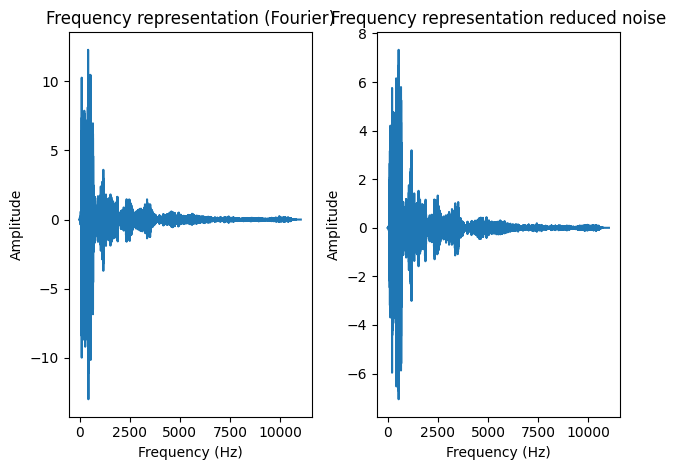

In [ ]:
sound_rfft = rfft(test_audio)
sound_rfreqs = rfftfreq(len(test_audio), 1.0/test_sample)
sound_rfft2 = rfft(reduced_noise_audio)
sound_rfreqs2 = rfftfreq(len(reduced_noise_audio), 1.0/test_sample)
plt.subplot(1, 2, 1)
plt.plot(sound_rfreqs, np.real(sound_rfft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation (Fourier)')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.plot(sound_rfreqs2, np.imag(sound_rfft2));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation reduced noise')
plt.tight_layout()
plt.show()

it cut some high frequnecies but after that the plots are nearly the same in count of task of emotional recognition this high noise could be usefull. We can hear on the video that after the noise reducition with have more robotic soundcuz the higher sounds got recuded

Conclusion - we dont want to reduce the noise

In [ ]:
mfccs = mfcc(y= test_audio*1.0, sr=test_sample)

We transforming freqtions into the coeficients and amplitue d  the same way

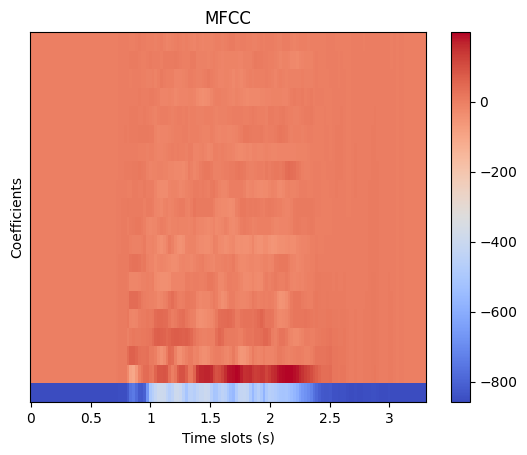

In [ ]:
specshow(mfccs, sr=test_sample, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

In [ ]:
#For machine learning algorithms that rely on gradient descent,
# large differences in feature scales can lead to slower convergence or even failure to converge.
# so we will try to normalize it
#and becouse the one row is one feture we want to normalized to habe smaller dirffences beetwen them in puropse of machine learning

In [ ]:
#Low-frequency components (low-index MFCCs) often carry significant information about the timbre or tone of the voice
#High-frequency components (higher-index MFCCs) might reflect harshness or sharpness in speech

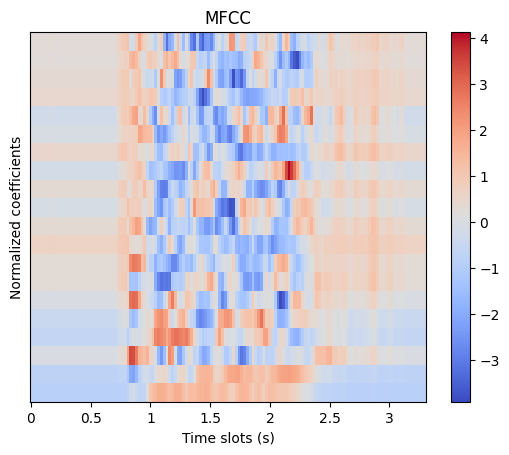

In [ ]:


# Normalize each MFCC coefficient using Z-score normalization (standardization)
scaler = StandardScaler()
mfccs_normalized = scaler.fit_transform(mfccs.T).T
specshow(mfccs_normalized, sr=test_sample, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Normalized coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

we think is more informativ becouse we treat it as a imnage so we normalized each row to be more usefull in porpse of ML

In [ ]:
mean_mfccs = np.mean(mfccs, axis=1)
std_mfccs = np.std(mfccs, axis=1)

print("Mean of MFCCs:", mean_mfccs)
print("Standard Deviation of MFCCs:", std_mfccs)

Mean of MFCCs: [-6.9779260e+02  5.4890041e+01  6.6346699e-01  1.2435785e+01
  7.7339516e+00  5.3075010e-01 -3.2166307e+00 -3.1593950e+00
 -1.0977551e+01 -2.8487110e+00  8.1529772e-01 -3.0370672e+00
  1.9554471e+00 -3.7356682e+00  4.3770078e-01  7.8235656e-01
 -4.0714283e+00 -1.8607761e+00 -1.3236903e+00 -9.2046309e-01]
Standard Deviation of MFCCs: [183.03044    72.16848    19.195799   20.930756   17.33931    13.761339
  10.853388   11.505454   17.019814    8.8651      8.66975     9.678136
   9.780213    7.676487    6.668202    3.2124755   9.426749    5.3808117
   6.2102585   3.49172  ]


#Clear and get the data

In [ ]:
 #mfcc mel-frequency cepstrum is a representation of the short-term power spectrum of a sound


In [ ]:


def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, duration=2.75, sr=44100, offset=0.5)
        # sr =44100 which is a common sample rate for audio processing offset=0.5 cuz the speaches in dataset starting after 0.5
        # rest_typ and duration to make the learning faster
        mfccs = mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        scaler = StandardScaler()
        mfccs_normalized = scaler.fit_transform(mfccs.T).T
        return mfccs_normalized
    except (LibsndfileError, EOFError) as e:
        print(f"Error processing file: {file_path}. Error: {e}")
        return np.nan

In [ ]:
x = extract_features("/content/drive/MyDrive/Digital Singals/data/Actor_01/03-01-01-01-01-01-01.wav")
print(x)

[[[-3.4641018  -3.4641018  -3.4641018  ... -3.4641018  -3.4641018
   -3.4641018 ]
  [ 0.28867513  0.28867513  0.28867513 ...  0.28867513  0.28867513
    0.28867513]
  [ 0.28867513  0.28867513  0.28867513 ...  0.28867513  0.28867513
    0.28867513]
  ...
  [ 0.28867513  0.28867513  0.28867513 ...  0.28867513  0.28867513
    0.28867513]
  [ 0.28867513  0.28867513  0.28867513 ...  0.28867513  0.28867513
    0.28867513]
  [ 0.28867513  0.28867513  0.28867513 ...  0.28867513  0.28867513
    0.28867513]]]


In [ ]:
!pip install soundfile
import soundfile as sf

In [ ]:
# Filename identifiers

# Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
# Vocal channel (01 = speech, 02 = song).
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
# Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
# Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
# Repetition (01 = 1st repetition, 02 = 2nd repetition).
# Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


In [ ]:
def load_data(data_folder='/content/drive/MyDrive/Digital Singals/data'):
    data = []
    labels = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            # Check if the file is a WAV file
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                try:
                    emotion = file.split("-")[2]
                    if emotion:  # Ensure that emotion is not empty
                        labels.append(emotion)
                        data.append(file_path)
                    else:
                        print(f"Skipping file with invalid label: {file}")
                except IndexError:
                    print(f"Skipping file with invalid filename format: {file}")

    return data, labels

In [ ]:
link,labels = load_data()

In [ ]:
df = pd.DataFrame({'link':link,'labels':labels })
map ={
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}
df = df.replace({'labels':map})
df.head()

,link,labels
0,/content/drive/MyDrive/Digital Singals/data/Ac...,neutral
1,/content/drive/MyDrive/Digital Singals/data/Ac...,neutral
2,/content/drive/MyDrive/Digital Singals/data/Ac...,neutral
3,/content/drive/MyDrive/Digital Singals/data/Ac...,neutral
4,/content/drive/MyDrive/Digital Singals/data/Ac...,calm


In [ ]:
df = df.dropna()

In [ ]:
df['link'] = df['link'].apply(extract_features)

<ipython-input-93-f69ba220c219>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, duration=2.75, sr=44100, offset=0.5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file: /content/drive/MyDrive/Digital Singals/data/Actor_02/03-01-04-02-02-02-02.wav. Error: 


In [ ]:
print((df['link'][0]))

[[-3.4641016  -3.4641016  -3.4641016  ... -3.4641016  -3.4641016
  -3.4641016 ]
 [ 0.28867516  0.28867516  0.28867516 ...  0.28867516  0.28867516
   0.28867516]
 [ 0.28867516  0.28867516  0.28867516 ...  0.28867516  0.28867516
   0.28867516]
 ...
 [ 0.28867516  0.28867516  0.28867516 ...  0.28867516  0.28867516
   0.28867516]
 [ 0.28867516  0.28867516  0.28867516 ...  0.28867516  0.28867516
   0.28867516]
 [ 0.28867516  0.28867516  0.28867516 ...  0.28867516  0.28867516
   0.28867516]]


In [ ]:

df.to_pickle('/content/drive/MyDrive/Digital Singals/data1.pkl')

#Classification

In [ ]:

df = pd.read_pickle('/content/drive/MyDrive/Digital Singals/data.pkl')

In [ ]:
df.head()

,link,labels
0,"[[-1.015127, -1.015127, -1.015127, -1.015127, ...",neutral
1,"[[-1.0576568, -1.0554277, -1.0609499, -1.04412...",neutral
2,"[[-0.9782761, -0.9782761, -0.9782761, -0.97827...",neutral
3,"[[-0.9878587, -0.9878587, -0.9878587, -0.98785...",neutral
4,"[[-1.2713784, -1.2713784, -1.2713784, -1.27137...",calm


In [ ]:
map ={
    'neutral':0,
    'calm':1,
    'happy':2,
    'sad':3,
    'angry':4,
    'fearful':5,
    'disgust':6,
    'surprised':7
}
df = df.replace({'labels':map})
df.head()
df = df.dropna()


<ipython-input-111-661047f04696>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'labels':map})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['link'], df['labels'], test_size=0.2, random_state=42)

LSTM networks include memory cells that allow them to retain information over longer time steps. These cells are able to store information and decide which data to keep and which to forget, making them very useful for tasks wit speach data.

In [ ]:
max_shape = max(x.shape[1] for x in X_train)

# Pad sequences with zeros to match the maximum shape
X_train_padded = [np.pad(x, ((0, 0), (0, max_shape - x.shape[1])), 'constant') for x in X_train]
X_test_padded = [np.pad(x, ((0, 0), (0, max_shape - x.shape[1])), 'constant') for x in X_test]

# Convert to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train_padded, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_padded, dtype=tf.float32)

# Reshape tensors to add channel dimension
X_train_tensor = tf.expand_dims(X_train_tensor, axis=-1)
X_test_tensor = tf.expand_dims(X_test_tensor, axis=-1)


In [ ]:

model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=X_train_tensor.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dense(128, activation='relu'))  # Additional Dense layer
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_tensor, y_train, batch_size=32, epochs=30, validation_data=(X_test_tensor, y_test))

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.1836 - loss: 2.0267 - val_accuracy: 0.2431 - val_loss: 1.9408
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3881 - loss: 1.7262 - val_accuracy: 0.3333 - val_loss: 1.8148
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4420 - loss: 1.4725 - val_accuracy: 0.4201 - val_loss: 1.6135
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5821 - loss: 1.2123 - val_accuracy: 0.4792 - val_loss: 1.4517
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6452 - loss: 1.0419 - val_accuracy: 0.5312 - val_loss: 1.3015
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7193 - loss: 0.7937 - val_accuracy: 0.5208 - val_loss: 1.3127
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7625 - loss: 0.6581 - val_accuracy: 0.5521 - val_loss: 1.3808
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8141 - loss: 0.5387 - val_accuracy: 0.5486 - v

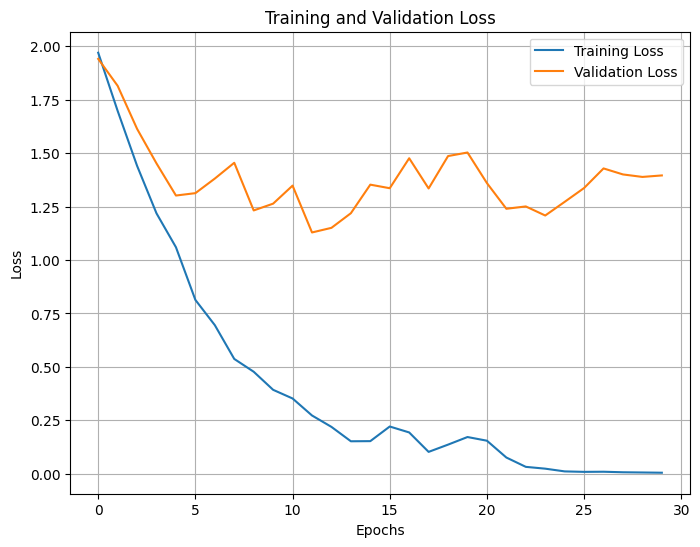

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

something went wrong as we see up there. hmmmm... stil in progress

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7256 - loss: 1.4024
Test accuracy: 0.72
